In [1]:
import os
import sys
from pathlib import Path

script_dir = Path(os.path.abspath(""))
base_dir = Path(*script_dir.parts[:-1])
sys.path.append( str(base_dir / 'src/') )
DATASET_DIR = base_dir / 'datasets'
FONT_DIR = base_dir / 'fonts'

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager
from scipy.spatial.distance import cosine, cdist, pdist, squareform, jaccard
from umap import UMAP
import numpy as np
from collections import defaultdict

from scipy.stats import pearsonr, kendalltau
from scipy.stats import linregress
import torch

from dataloader import DatasetLoader
from dataloader.representations.graph_utils import EDGE_DIM, NODE_DIM, from_smiles
from pom.gnn.graphnets import GraphNets
from chemix import build_chemix, get_mixture_smiles
from pommix_utils import pna

import torchmetrics
import json
from ml_collections import ConfigDict
from torch_geometric.data import Batch
from rdkit.Chem import MolFromSmiles, MolToSmiles

from argparse import ArgumentParser
from pommix_utils import bootstrap_ci
from chemix.utils import TORCH_METRIC_FUNCTIONS
from dataloader import DatasetLoader, SplitLoader
import re

# Max rows in pandas unlimited
pd.set_option('display.max_rows', None)


if False:
    font_files = font_manager.findSystemFonts(fontpaths=str(FONT_DIR))

    for font_file in font_files:
        font_manager.fontManager.addfont(font_file)

    plt.rcParams['font.family'] = 'DM Sans 24pt'
else:
    from pommix_utils import set_visualization_style
    set_visualization_style()
    

%load_ext autoreload 
%autoreload 2

/u/ctser/.conda/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/h/292/ctser/pom-mix/datasets
Load preferred font.


In [2]:
mean_df = pd.read_csv(DATASET_DIR / "mixtures/mixture_rdkit_mean_definitions_clean.csv")
pna_df = pd.read_csv(DATASET_DIR / "mixtures/mixture_rdkit_definitions_clean.csv")
mix_df = pd.read_csv(DATASET_DIR / "mixtures/mixtures_combined.csv")
smi_df = pd.read_csv(DATASET_DIR / "mixtures/mixture_smi_definitions_clean.csv")

if True:
    unique_mean_df = mean_df[mean_df['Duplicate'] == False].copy()
    unique_mean_df.drop(columns=['Duplicate', 'Duplicate Of'], inplace=True)
    unique_pna_df = pna_df[pna_df['Duplicate'] == False].copy()
    unique_pna_df.drop(columns=['Duplicate', 'Duplicate Of'], inplace=True)
    unique_smi_df = smi_df[smi_df['Duplicate'] == False].copy()
    unique_smi_df.drop(columns=['Duplicate', 'Duplicate Of'], inplace=True)

# Figure 2

In [3]:

def get_aggregate(dataset, mixture_id, df):
    return df[(df["Dataset"] == dataset) & (df["Mixture Label"] == mixture_id)].iloc[0, 2:].to_numpy(dtype="float32")

def get_cosine(dataset, mixture1, mixture2, df, distance='cosine'):
    mix1 = get_aggregate(dataset, mixture1, df)
    mix2 = get_aggregate(dataset, mixture2, df)
    return cosine(mix1, mix2)

In [4]:
plot_pna_df = pd.merge(unique_smi_df[['Dataset', 'Mixture Label', 'length']], unique_pna_df, on=["Dataset", "Mixture Label"], how='left')
plot_pna_df['Master Dataset'] = plot_pna_df['Dataset'].apply(lambda x: x.split(" ")[0])
umap_model = UMAP(metric = 'cosine', densmap=True, random_state=42, low_memory = False)
X_umap = umap_model.fit_transform(list(plot_pna_df[plot_pna_df.columns[3:-1]].values))
plot_pna_df["UMAP_0"], plot_pna_df["UMAP_1"] = X_umap[:,0], X_umap[:,1]

/u/ctser/.conda/envs/ml/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


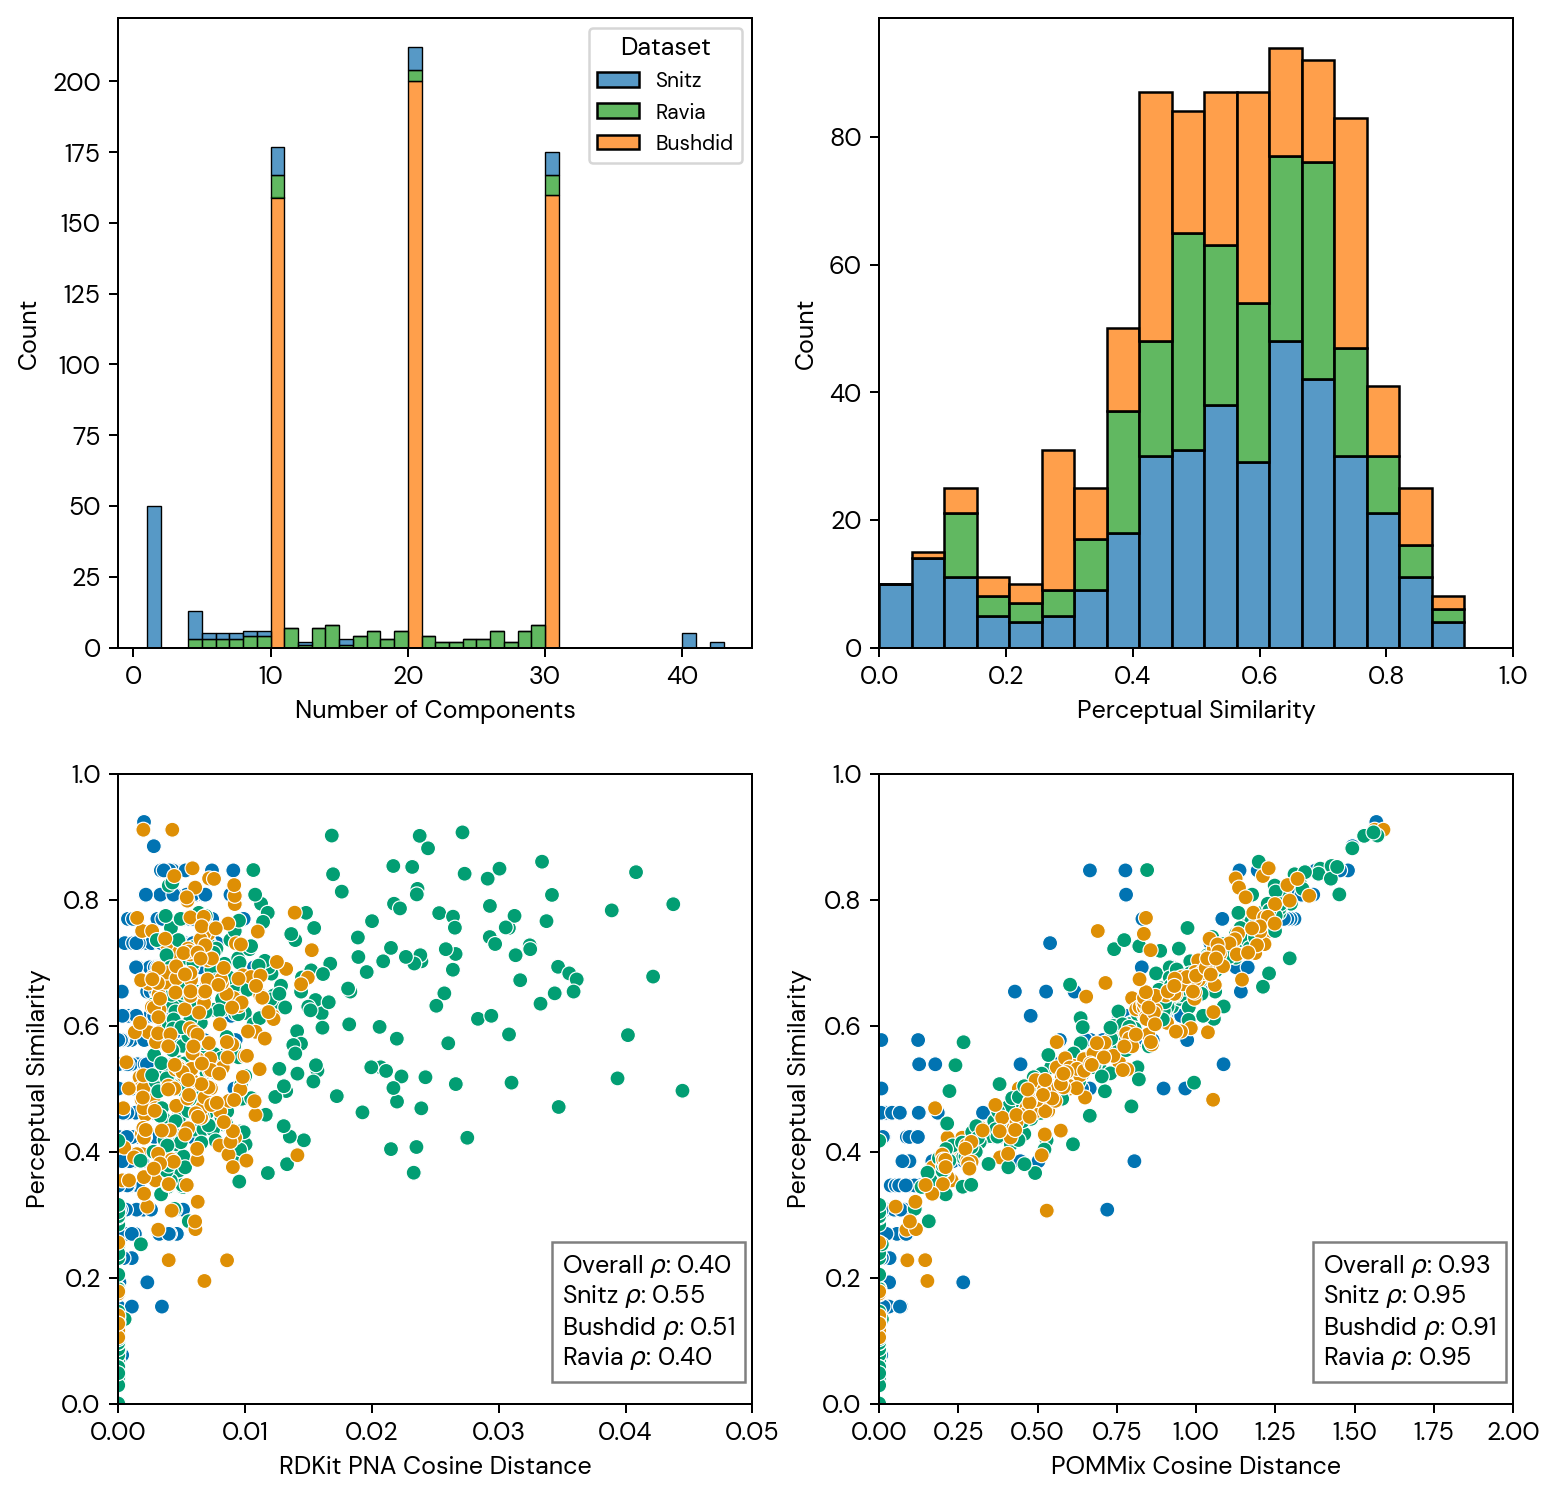

In [5]:
fig, ax = plt.subplots(2,2, figsize=(10,10), dpi=180)

dataset_colors = {"Snitz": 'tab:blue', 'Bushdid': 'tab:orange', 'Ravia': 'tab:green'}

plot_smi_df = unique_smi_df.copy()
plot_smi_df['Dataset'] = plot_smi_df['Dataset'].apply(lambda x: x.split(" ")[0])
g2 = sns.histplot(plot_smi_df, x='length', hue='Dataset', palette=dataset_colors, multiple='stack', ax=ax[0][0], binwidth=1)   

ax[0][0].set_xlabel("Number of Components")
ax[0][0].set_ylabel("Count")
#ax[0][1].set_yscale('log')

plot_mix_df = mix_df.copy()
plot_mix_df['Dataset'] = plot_mix_df['Dataset'].apply(lambda x: x.split(" ")[0])
g3 = sns.histplot(plot_mix_df, x='Experimental Values', hue='Dataset', palette=dataset_colors, multiple='stack', ax=ax[0][1])

#ax[2].set_yscale('log')
ax[0][1].set_xlim([0, 1])
ax[0][1].set_xlabel("Perceptual Similarity")
ax[0][1].get_legend().remove()

cosine_pna_df = pna_df.copy()
cosine_pna_df.drop(columns=['Duplicate', 'Duplicate Of'], inplace=True)
plot_mix_df = mix_df.copy()

plot_mix_df["PNA Cosine Distance"] = plot_mix_df.apply(lambda row: get_cosine(row["Dataset"], row["Mixture 1"], row["Mixture 2"], cosine_pna_df), axis=1)

plot_mix_df['Dataset'] = plot_mix_df['Dataset'].str.replace(' 1', '').str.replace(' 2', '').str.replace(' 3', '').str.replace(' 4', '')
feat_name = 'PNA'

g4 = sns.scatterplot(x="PNA Cosine Distance", y='Experimental Values', data=plot_mix_df, hue='Dataset', ax=ax[1][0])

r, _ = pearsonr(plot_mix_df[f'{feat_name} Cosine Distance'], plot_mix_df['Experimental Values'])
snitz_r, _ = pearsonr(plot_mix_df[plot_mix_df['Dataset'] == 'Snitz'][f'{feat_name} Cosine Distance'], plot_mix_df[plot_mix_df['Dataset'] == 'Snitz']['Experimental Values'])
bushdid_r, _ = pearsonr(plot_mix_df[plot_mix_df['Dataset'] == 'Bushdid'][f'{feat_name} Cosine Distance'], plot_mix_df[plot_mix_df['Dataset'] == 'Bushdid']['Experimental Values'])
ravia_r, _ = pearsonr(plot_mix_df[plot_mix_df['Dataset'] == 'Ravia'][f'{feat_name} Cosine Distance'], plot_mix_df[plot_mix_df['Dataset'] == 'Ravia']['Experimental Values'])
ax[1][1].text(0.7, 0.05, f'Overall $\\rho$: {r:.2f}\n' 
                    f'Snitz $\\rho$: {snitz_r:.2f}\n'
                    f'Bushdid $\\rho$: {bushdid_r:.2f}\n'
                    f'Ravia $\\rho$: {ravia_r:.2f}', transform=ax[1][0].transAxes,
                    verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.5))         

ax[1][0].set_ylim([0, 1])
#ax.set_title("Mixture PNA Cosine Distance vs. Perceptual Similarity")
ax[1][0].set_xlabel("RDKit PNA Cosine Distance")
ax[1][0].set_ylabel("Perceptual Similarity")
ax[1][0].set_xlim([0, 0.05])
ax[1][0].get_legend().remove()

pommix_df = smi_df.copy()
pommix_df.drop(columns=['Duplicate', 'Duplicate Of'], inplace=True)
dataset_id = pommix_df['Dataset'].values

for model in ['model']:
# load chemix model and get embedding=
    pommix_path = base_dir / f"scripts/pommix/results/random_train_val/{model}"
    hp_gnn = ConfigDict(json.load(open(pommix_path / 'hparams_graphnets.json', 'r')))
    embedder = GraphNets(node_dim=NODE_DIM, edge_dim=EDGE_DIM, **hp_gnn)
    embedder.load_state_dict(torch.load(pommix_path / 'random_train_val_gnn_embedder.pt'))
    embedder.eval()
    hp_mix = ConfigDict(json.load(open(pommix_path / f'hparams_chemix.json', 'r')))
    chemix = build_chemix(config=hp_mix.chemix)
    chemix.load_state_dict(torch.load(pommix_path / 'random_train_val_chemix.pt'))
    chemix.eval()

    # the smiles
    mixtures = np.array([mix[mix != ''] for mix in  pommix_df.fillna('')[[f'smi_{i}' for i in range(43)]].values], dtype=object).reshape(-1, 1)
    graph_list, indices = get_mixture_smiles(mixtures, from_smiles)
    train_gr = Batch.from_data_list(graph_list)
    out = embedder.graphs_to_mixtures(train_gr, indices)
    pommix_embeds = chemix.embed(out).detach().numpy().squeeze()
    pommix_df[f'pommix_{model}_embed'] = list(pommix_embeds)

def get_embedding(df, dataset, mixture_id, embedding_type):
    return df[(df['Dataset'] == dataset) & (df['Mixture Label'] == mixture_id)][embedding_type].values[0]

def embedding_cosine_distance(df, dataset, mixture_1, mixture_2, embedding_type):
    return cosine(get_embedding(df, dataset, mixture_1, embedding_type), get_embedding(df, dataset, mixture_2, embedding_type))

embed_df = mix_df.copy()
embed_df['POMMix Cosine Distance'] = embed_df.apply(lambda row: embedding_cosine_distance(pommix_df, row['Dataset'], row['Mixture 1'], row['Mixture 2'], f'pommix_model_embed'), axis=1)
embed_df['Dataset'] = embed_df['Dataset'].str.replace(' 1', '').str.replace(' 2', '').str.replace(' 3', '').str.replace(' 4', '')

g4 = sns.scatterplot(embed_df, x=f'POMMix Cosine Distance', y='Experimental Values', hue='Dataset', ax=ax[1][1], legend=False)

r, _ = pearsonr(embed_df[f'POMMix Cosine Distance'], embed_df['Experimental Values'])
snitz_r, _ = pearsonr(embed_df[embed_df['Dataset'] == 'Snitz'][f'POMMix Cosine Distance'], embed_df[embed_df['Dataset'] == 'Snitz']['Experimental Values'])
bushdid_r, _ = pearsonr(embed_df[embed_df['Dataset'] == 'Bushdid'][f'POMMix Cosine Distance'], embed_df[embed_df['Dataset'] == 'Bushdid']['Experimental Values'])
ravia_r, _ = pearsonr(embed_df[embed_df['Dataset'] == 'Ravia'][f'POMMix Cosine Distance'], embed_df[embed_df['Dataset'] == 'Ravia']['Experimental Values'])
ax[1][1].text(0.7, 0.05, f'Overall $\\rho$: {r:.2f}\n' 
                    f'Snitz $\\rho$: {snitz_r:.2f}\n'
                    f'Bushdid $\\rho$: {bushdid_r:.2f}\n'
                    f'Ravia $\\rho$: {ravia_r:.2f}', transform=ax[1][1].transAxes,
                    verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.5))           
ax[1][1].set_ylim([0,1])   
ax[1][1].set_xlim([0,2])     
# ax.set_title(feat_name)
ax[1][1].set_xlabel(f'POMMix Cosine Distance')
ax[1][1].set_ylabel('Perceptual Similarity')    



plt.savefig("figure2.png", bbox_inches='tight')
plt.savefig("figure2.svg", bbox_inches='tight')

# Figure 5

mixtures dataset is known to have invalid entries. Validation is turned off.


/u/ctser/.conda/envs/ml/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


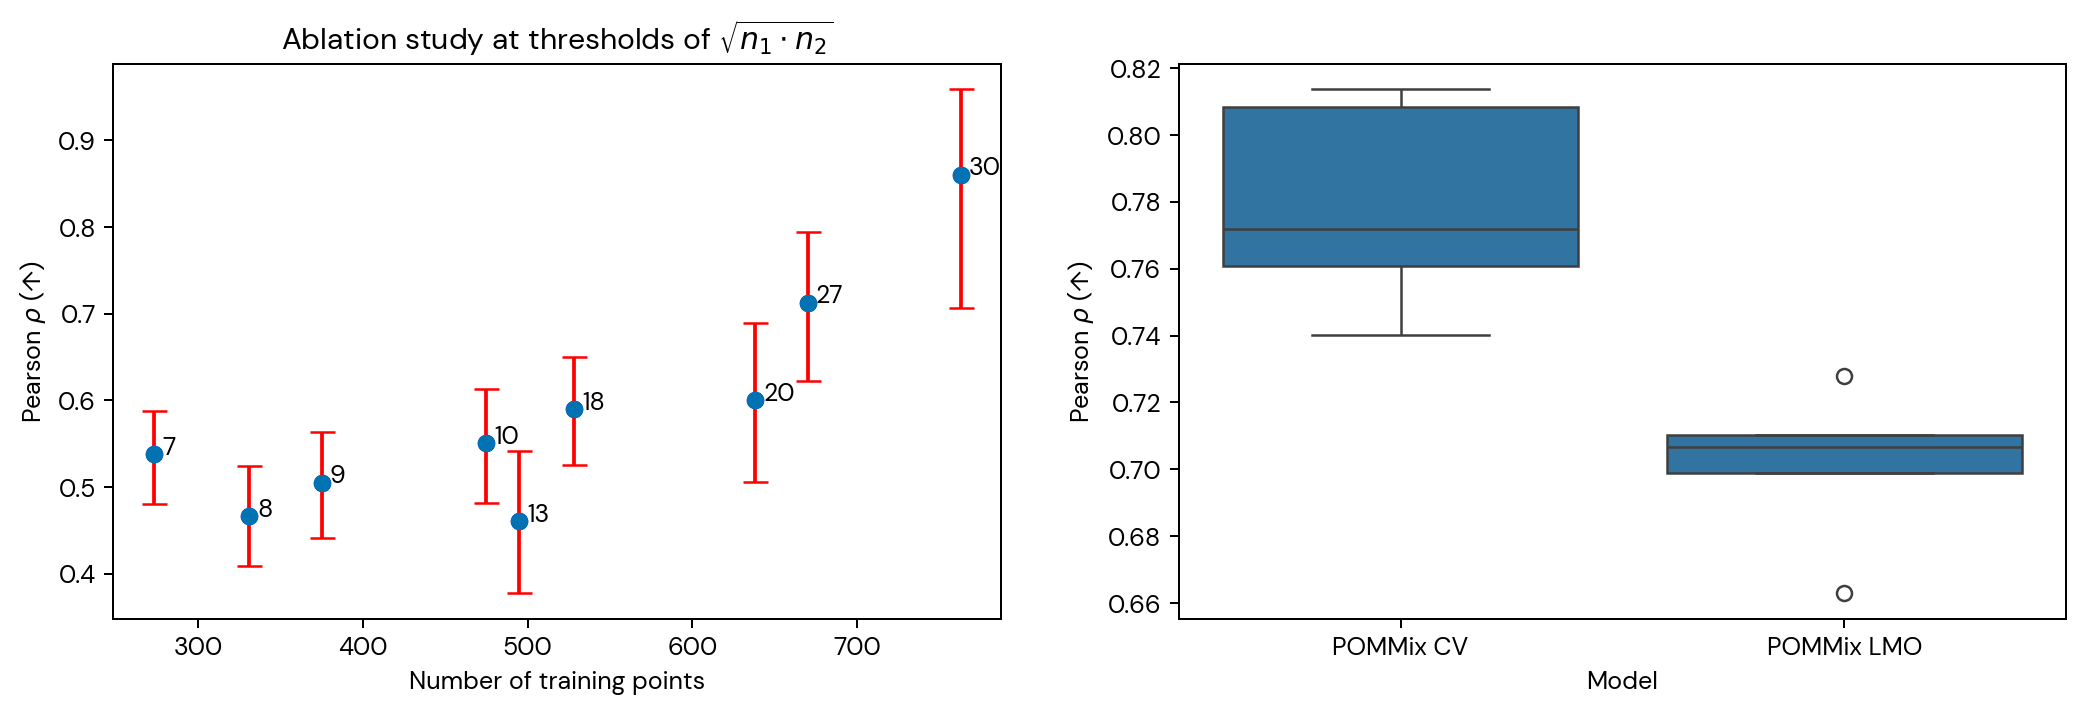

In [11]:
fig,ax = plt.subplots(1,2, figsize=(14, 4), dpi=180)

parser = ArgumentParser()
parser.add_argument("--split", action="store", type=str, default="ablate_components", choices=["ablate_molecules", "ablate_components"])
FLAGS = parser.parse_args(args=[])

DATA_DIR = base_dir / Path(f'scripts/pommix/results/{FLAGS.split}/model')

# training set
dl = DatasetLoader()
dl.load_dataset('mixtures')
dl.featurize('mix_smiles')

sl = SplitLoader(FLAGS.split)
X, Y, y_upper, y_lower, label = [], [], [], [], []
for id, train, _, test in sl.load_splits(dl.features, dl.labels):
    train_feat, _  = train
    df = pd.read_csv(DATA_DIR / f"{id}_test_predictions.csv")
    lab = re.findall(r'\d+', id)

    x = len(train_feat)
    metric_fn = TORCH_METRIC_FUNCTIONS['pearson']
    y_true = torch.from_numpy(df['Predicted_Experimental_Values'].to_numpy(np.float32))
    y_pred = torch.from_numpy(df['Ground_Truth'].to_numpy(np.float32))
    lower_bound, upper_bound, values = bootstrap_ci(y_true, y_pred, metric_fn)
    X.append(x)
    Y.append(np.mean(values))
    y_upper.append(upper_bound)
    y_lower.append(lower_bound)
    label.extend(lab)


ax[0].errorbar(X, Y, yerr=[np.array(Y) - np.array(y_lower), np.array(y_upper) - np.array(Y)], fmt='o', ecolor='r', capsize=5)
ax[0].scatter(X, Y, color='b')
for i, txt in enumerate(label):
    ax[0].annotate(txt, (X[i]+5, Y[i]))

ax[0].set_xlabel('Number of training points')
ax[0].set_ylabel(r'Pearson $\rho$ (↑)')
ax[0].set_title(r'Ablation study at thresholds of $\sqrt{n_1 \cdot n_2}$')

###### 
all_df = []
samples_df = []
model_order = [
    'POMMix CV',
    'POMMix LMO']

for split, filename, tag in zip(
    ['cv', 'lso',],
    [   
        base_dir / 'scripts/pommix/results/random_cv/model',
        base_dir / 'scripts/pommix/results/lso_molecules/model',
    ], 
    model_order
):
    results = []
    samples = {}
    for key, metric_fn in TORCH_METRIC_FUNCTIONS.items():
        tmp = []
        for i in range(5):
            pred_fname = filename / f'{split}{i}_test_predictions.csv'

            df = pd.read_csv(pred_fname)
            y_true = torch.from_numpy(df['Predicted_Experimental_Values'].to_numpy(np.float32))
            y_pred = torch.from_numpy(df['Ground_Truth'].to_numpy(np.float32))

            met = metric_fn(y_pred, y_true)
            tmp.append(met.item())

        # mu = np.mean(tmp)
        # std = np.std(tmp)
        info = {'metric': [key]*len(tmp), 'value': tmp, 'split': [split]*len(tmp)}
        results.append(pd.DataFrame(info))

    # samples = pd.DataFrame(samples)
    # samples['fname'] = tag
    # samples_df.append(samples)
    results = pd.concat(results)
    results['fname'] = tag
    all_df.append(results)

all_df = pd.concat(all_df)
# samples_df = pd.concat(samples_df)

all_df.to_csv('compiled_metrics.csv', index=False)
# samples_df.to_csv('compiled_metrics_significance.csv', index=False)
metrics = all_df['metric'].unique()

metric_data = all_df[all_df['metric'] == 'pearson']

# Create a figure with 3 subplots
sns.boxplot(data=metric_data, x='fname', y='value', hue='fname', palette={'POMMix CV': 'tab:blue', 'POMMix LMO': 'tab:blue'}, ax=ax[1], order=model_order)

# axs[i].locator_params(axis='x', nbins=7)
ax[1].set_ylabel(r'Pearson $\rho$ (↑)')
ax[1].set_xlabel(f'Model')

plt.savefig("figure5.png", bbox_inches='tight')
plt.savefig("figure5.svg", bbox_inches='tight')

# Figure 6

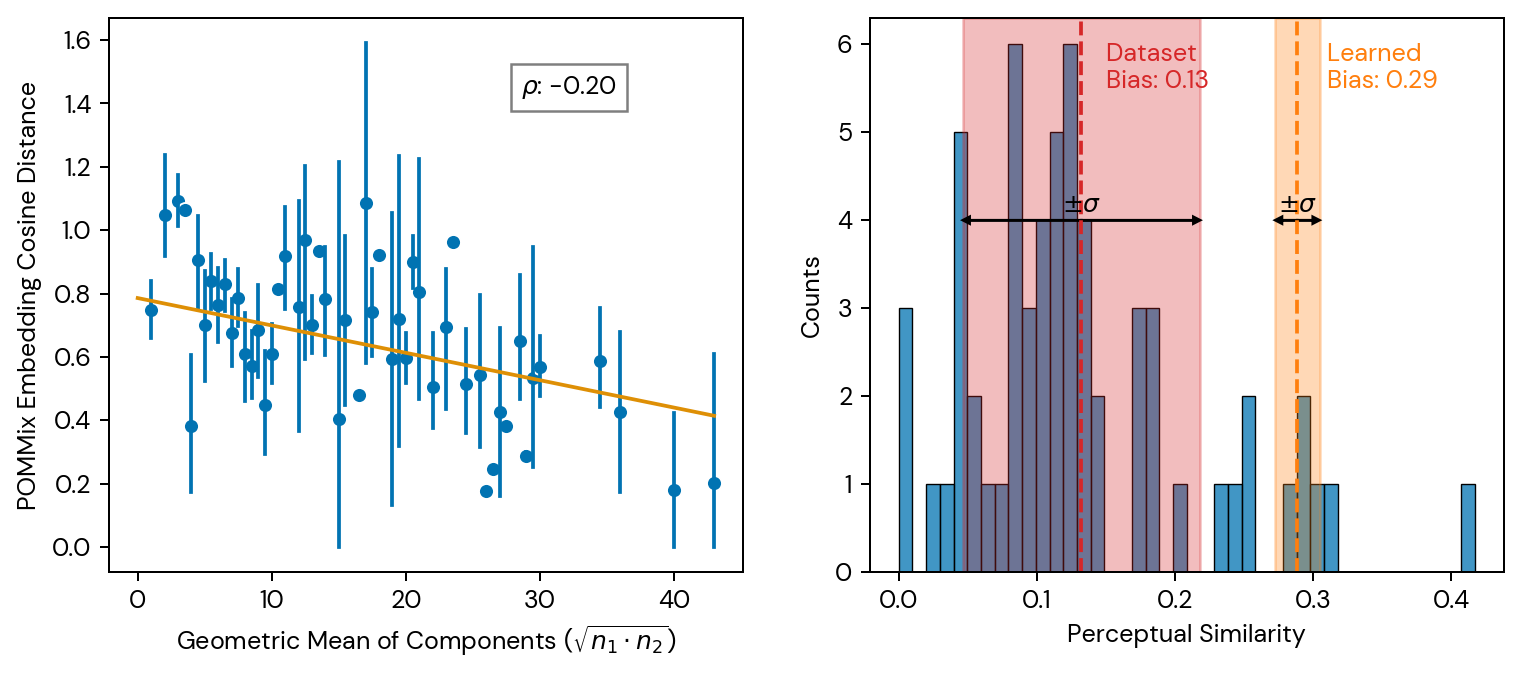

In [15]:
white_noise_df = pd.read_csv("pommix_white_noise.csv")

fig, ax = plt.subplots(1,2, figsize=(10,4), dpi=180)
lp = sns.lineplot(data=white_noise_df, x=r"$\sqrt{n_1 \cdot n_2}$", y="Cosine distance", linestyle='', err_style='bars', marker='o', ax=ax[0])

m, b, rho, p, _ = linregress(white_noise_df[r"$\sqrt{n_1 \cdot n_2}$"].values.flatten(), white_noise_df["Cosine distance"].values.flatten())
x_fit = np.linspace(0, 43)
y_fit = m*x_fit + b

ax[0].plot(x_fit, y_fit)
ax[0].set_ylabel("POMMix Embedding Cosine Distance")
ax[0].set_xlabel(r"Geometric Mean of Components ($\sqrt{n_1 \cdot n_2}$)")
ax[0].text(0.65, 0.85, f'$\\rho$: {rho:.2f}',
        transform=ax[0].transAxes,
        verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.5))     

same_df = mix_df[mix_df['Mixture 1'] == mix_df['Mixture 2']].copy()

g2 = sns.histplot(same_df['Experimental Values'].values, binwidth=0.01, ax=ax[1])
mix_mean = same_df['Experimental Values'].mean()
mix_std = same_df['Experimental Values'].std()

ax[1].axvline(mix_mean, color='tab:red', linestyle='--', label='Self-Mixture Mean')
ax[1].text(0.15, 5.5, f'Dataset \nBias: {mix_mean:.2f}', fontsize=10, color='tab:red')
ax[1].axvspan(mix_mean - mix_std, mix_mean + mix_std, alpha=0.3, color='tab:red', label='Dataset Mean ± 1 SD')

ax[1].arrow(x=mix_mean, y=4, dx=-mix_std, dy=0, color='black', length_includes_head=True, head_width=0.08, head_length=0.005)
ax[1].arrow(x=mix_mean, y=4, dx=mix_std, dy=0, color='black', length_includes_head=True, head_width=0.08, head_length=0.005)
ax[1].text(mix_mean, 4.1, f'$\pm\sigma$', fontsize=10, color='black', ha='center')


# load chemix model and get embeddings
pommix_path = base_dir / "scripts/pommix/results/random_cv/model"
model_biases = []
for i in range(5): 
    model_biases.append(torch.load(pommix_path / f'cv{i}_chemix.pt')['regressor.scaler.bias'].cpu().numpy()[0])

bias_mean = np.mean(model_biases)
bias_std = np.std(model_biases)

ax[1].axvspan(bias_mean - bias_std, bias_mean + bias_std, alpha=0.3, color='tab:orange', label='POMMix Bias ± 1 SD')
ax[1].axvline(bias_mean, color='tab:orange', linestyle='--', label='POMMix Bias Mean')

ax[1].text(0.31, 5.5, f'Learned \nBias: {bias_mean:.2f}', fontsize=10, color='tab:orange')
ax[1].arrow(x=bias_mean, y=4, dx=-bias_std, dy=0, color='black', length_includes_head=True, head_width=0.08, head_length=0.005)
ax[1].arrow(x=bias_mean, y=4, dx=bias_std, dy=0, color='black', length_includes_head=True, head_width=0.08, head_length=0.005)
ax[1].text(bias_mean, 4.1, f'$\pm\sigma$', fontsize=10, color='black', ha='center')


#g2.set_title("Perceptual Distances of Self-Mixtures")
g2.set_ylabel('Counts')
g2.set_xlabel("Perceptual Similarity")

#ax[1].legend()

plt.savefig("figure6.png", bbox_inches='tight')
#plt.savefig("figure6.svg", bbox_inches='tight')

# Appendix A.4

In [13]:
directories = {'snitz_baseline': base_dir / 'scripts/baseline/snitz_similarity',
               'xgb_rdkit2d': base_dir / 'scripts/baseline/xgb_rdkit2d',
               'xgb_pom_embeddings': base_dir / 'scripts/baseline/xgb_pom_embeddings',
               'chemix': base_dir / 'scripts/chemix/results/random_cv/model',
               'pommix': base_dir / 'scripts/pommix/results/random_cv/model',
               "pommix_nobias": base_dir / 'scripts/pommix/results/random_cv/model_no_bias'}

nice_names = {'snitz_baseline': "Snitz Baseline" ,
               'xgb_rdkit2d': "XGBoost + RDKit 2D",
               'xgb_pom_embeddings': "XGBoost + POM",
               'chemix': "CheMix + POM",
               'pommix': "POMMix",
               'pommix_nobias': "POMMix (No Bias)"}

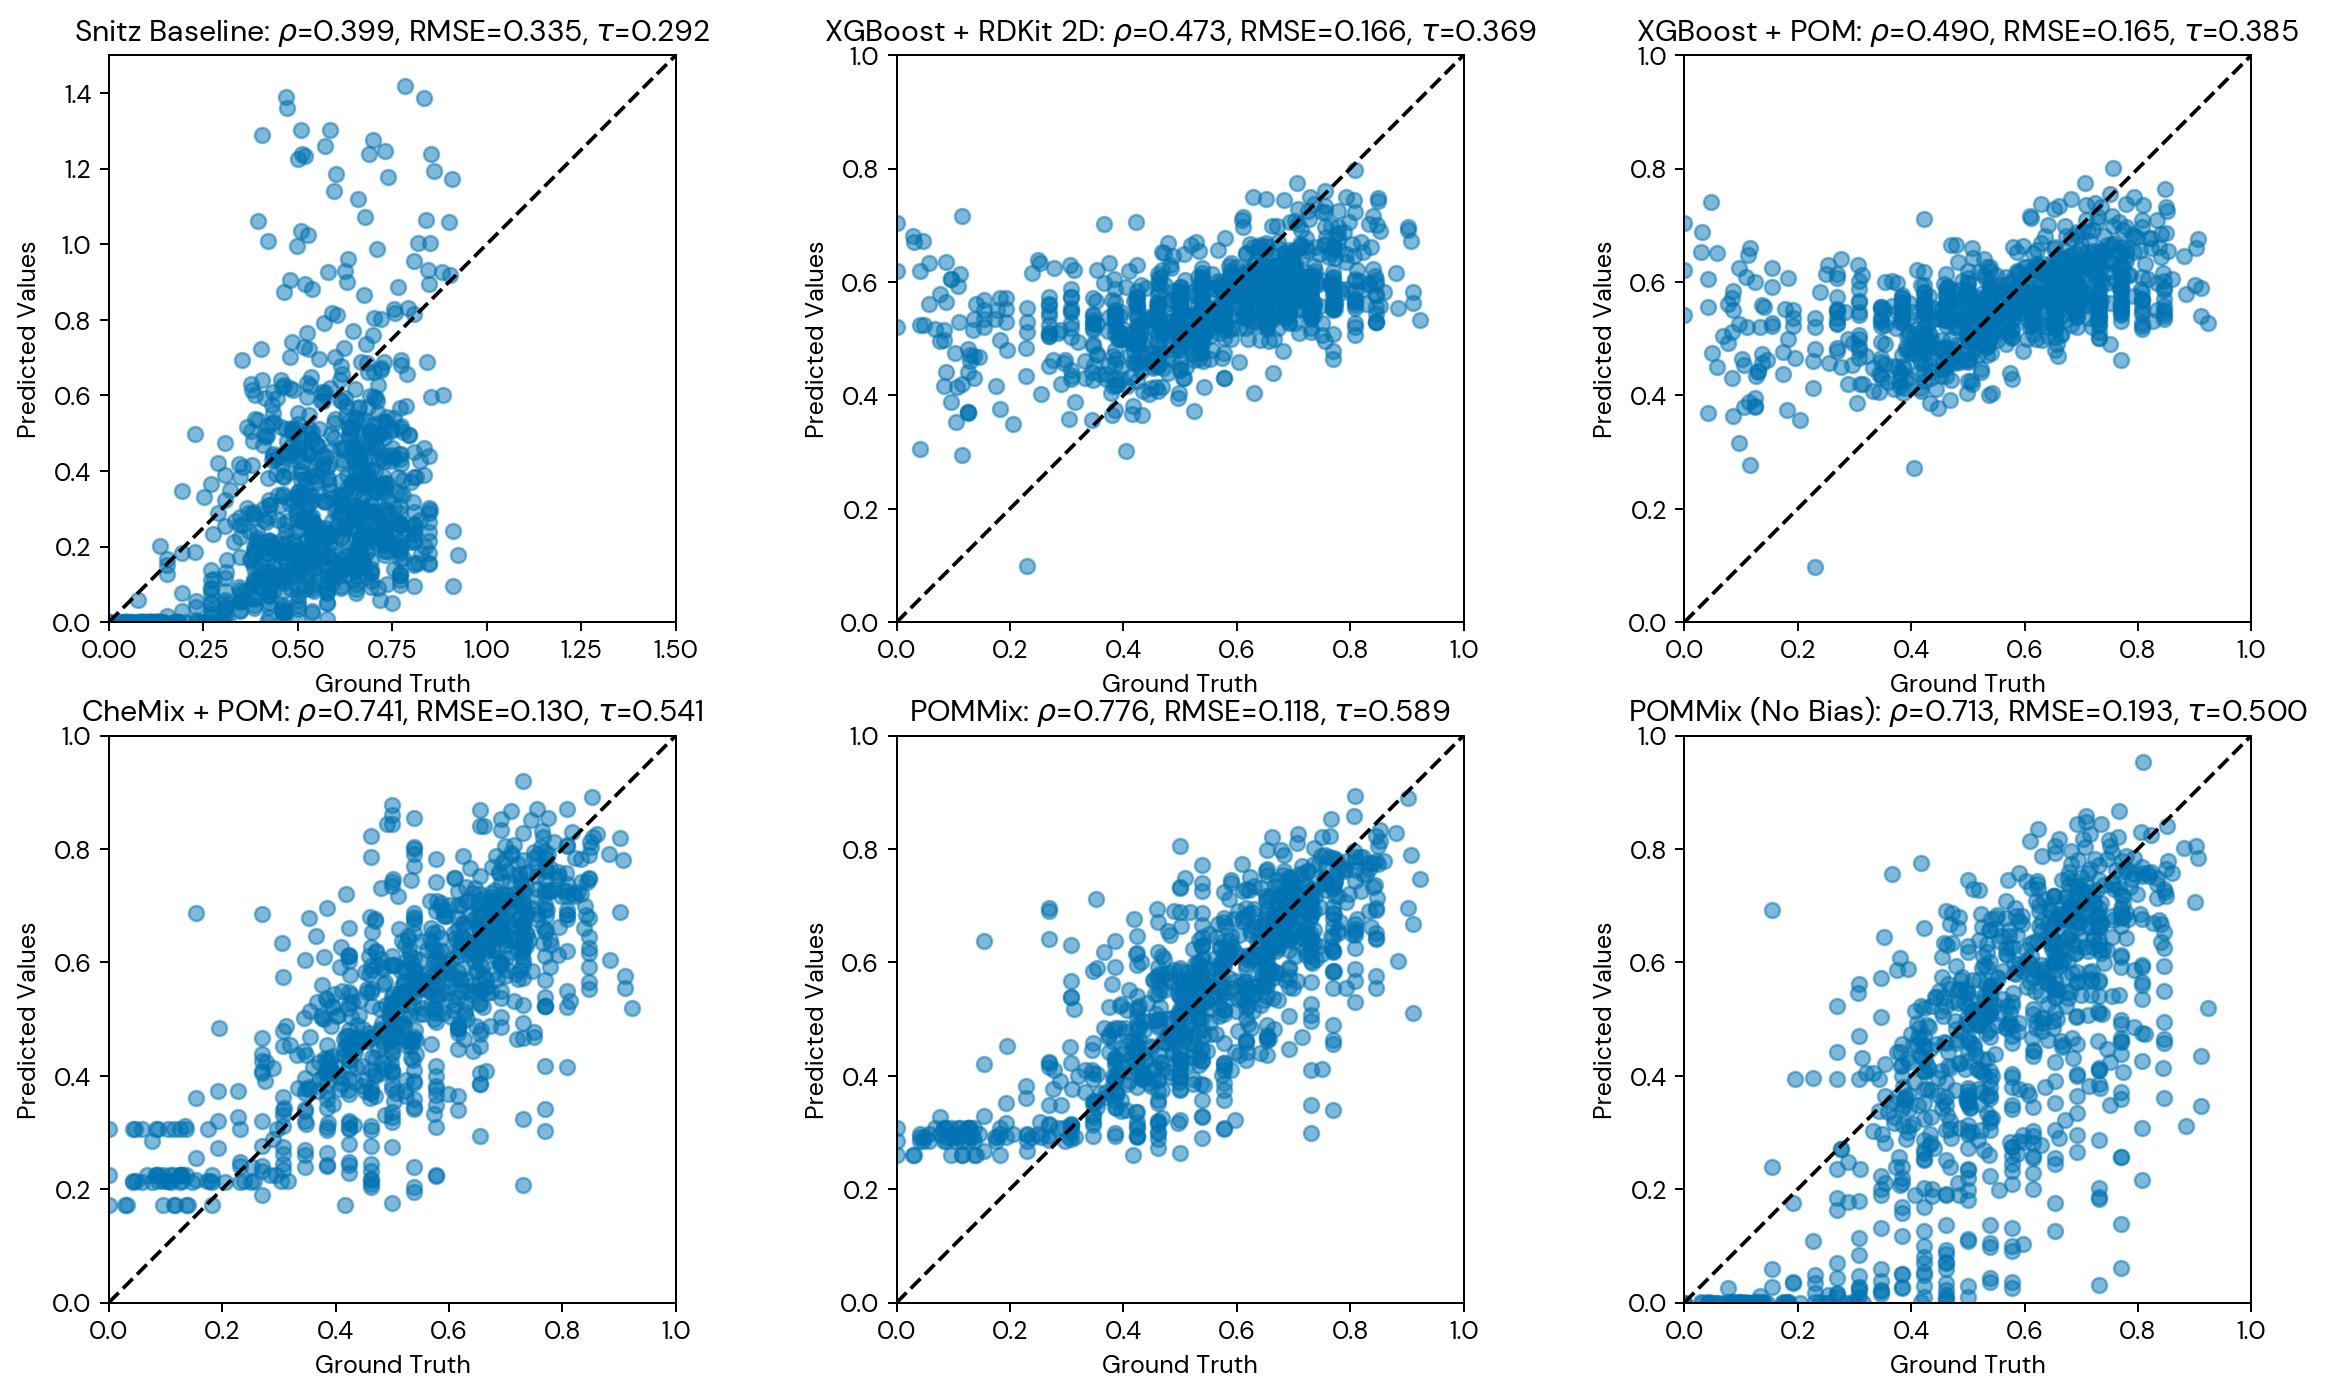

In [14]:
# Make a parity plot that averages over the 5 folds

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

fig, ax = plt.subplots(2, 3, figsize=(16, 9), dpi=180)

for i, directory in enumerate(directories.keys()):
    j = i // 3
    k = i % 3

    all_y_true = []
    all_y_pred = []
    
    for i in range(5):
        pred_fname = directories[directory] / f'cv{i}_test_predictions.csv'

        df = pd.read_csv(pred_fname)
        y_pred = df['Predicted_Experimental_Values'].to_numpy(dtype=np.float32)
        y_true = df['Ground_Truth'].to_numpy(dtype=np.float32)
        
        all_y_pred.append(y_pred)
        all_y_true.append(y_true)
        
    all_y_pred = np.array(all_y_pred).flatten()
    all_y_true = np.array(all_y_true).flatten()

    r, _ = pearsonr(all_y_true, all_y_pred)
    rmse_value = rmse(all_y_true, all_y_pred)
    kendall, _ = kendalltau(all_y_true, all_y_pred)
    
    # Plot scatter with error bars
    ax[j][k].scatter(all_y_true, all_y_pred, alpha=0.5)
    ax[j][k].set_title(rf'{nice_names[directory]}: $\rho$={r:.3f}, RMSE={rmse_value:.3f}, $\tau$={kendall:.3f}')
    if directory == 'snitz_baseline':
        ax[j][k].set_ylim([0,1.5])
        ax[j][k].set_xlim([0,1.5])
    else:
        ax[j][k].set_ylim([0,1])
        ax[j][k].set_xlim([0,1])
    ax[j][k].set_xlabel("Ground Truth")
    ax[j][k].set_ylabel("Predicted Values")
    ax[j][k].set_aspect('equal')
    ax[j][k].plot([0, 1.5], [0, 1.5], color='black', linestyle='--')

    plt.savefig(f"figurea4.png", bbox_inches='tight')
    plt.savefig(f"figurea4.svg", bbox_inches='tight')


# Appendix A.5

/h/292/ctser/pom-mix/src/chemix/model.py:542: UserWarning: chemix.regressor.no_bias not found, using default `False`
  warnings.warn("chemix.regressor.no_bias not found, using default `False`")
/h/292/ctser/pom-mix/src/chemix/model.py:542: UserWarning: chemix.regressor.no_bias not found, using default `False`
  warnings.warn("chemix.regressor.no_bias not found, using default `False`")
/tmp/ipykernel_1257082/1633869057.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g3.set_xticklabels(['POMMix', 'POMMix\nAugmented'])


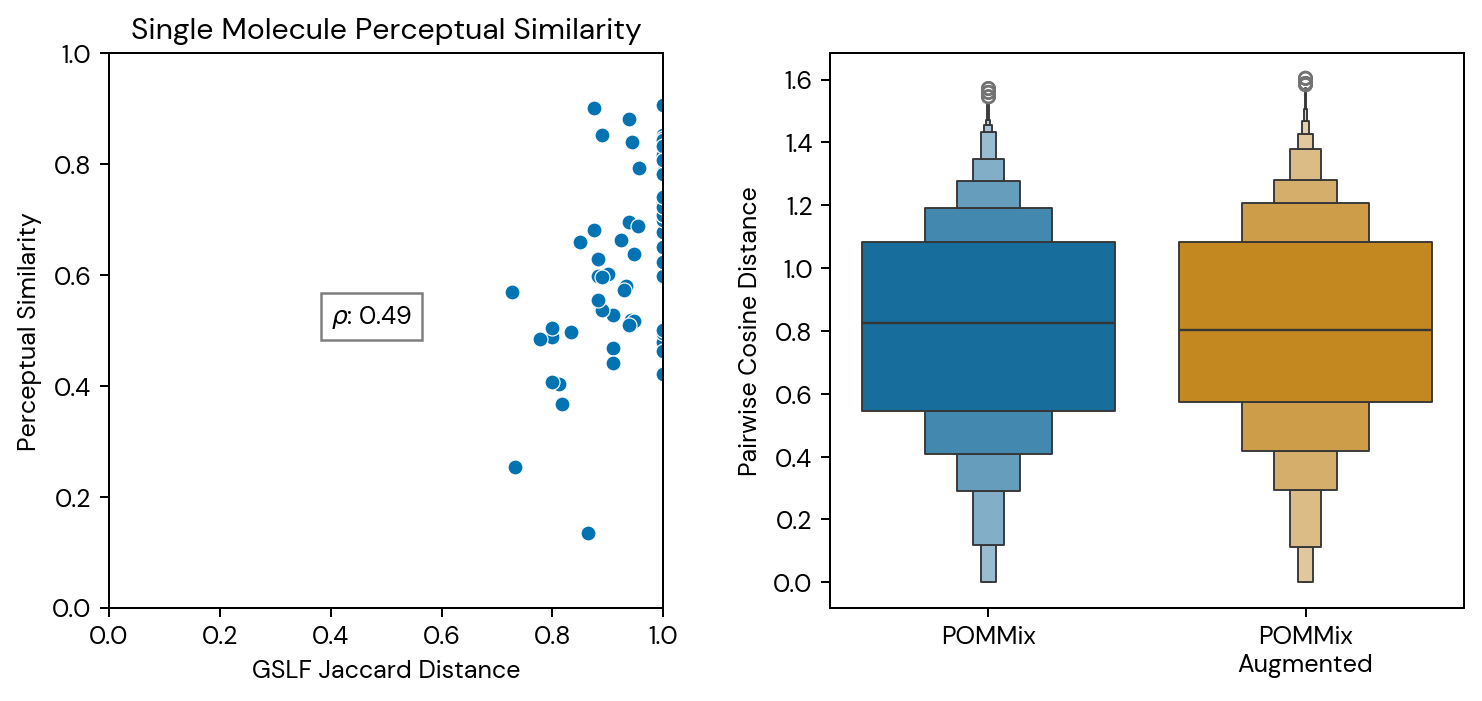

In [14]:
gslf_df = pd.read_csv(DATASET_DIR / "gs-lf/gs-lf_combined.csv")
snitz_3_df = pd.read_csv(DATASET_DIR /"mixtures/snitz_2013/snitz3_jaccard.csv")
snitz_3_df['Mixture 1'] = snitz_3_df.apply(lambda row: MolToSmiles(MolFromSmiles(row['Mixture 1'])), axis=1)
snitz_3_df['Mixture 2'] = snitz_3_df.apply(lambda row: MolToSmiles(MolFromSmiles(row['Mixture 2'])), axis=1)

fig, ax = plt.subplots(1,2, figsize=(10,4), dpi=180)

def get_gslf_labels(df, smiles):
    query_df = df[df['IsomericSMILES'] == smiles]
    if len(query_df) == 0:
        return None
    else:
        return query_df.iloc[0, 2:].to_numpy(dtype="float32")

def get_jaccard_distance(gslf_df, mixture1, mixture2):
    mix1 = get_gslf_labels(gslf_df, mixture1)
    mix2 = get_gslf_labels(gslf_df, mixture2)
    if mix1 is None or mix2 is None:
        return np.nan
    else:
        return jaccard(mix1, mix2)

snitz_3_df['GSLF Jaccard'] = snitz_3_df.apply(lambda row: get_jaccard_distance(gslf_df, row['Mixture 1'], row['Mixture 2']), axis=1)
snitz_3_df.dropna(inplace=True)

g = sns.scatterplot(x='GSLF Jaccard', y='Experimental Values', data=snitz_3_df, ax=ax[0])
ax[0].set_aspect('equal')
ax[0].set_xlim([0,1])
ax[0].set_ylim([0,1])
ax[0].set_ylabel('Perceptual Similarity')
ax[0].set_xlabel('GSLF Jaccard Distance')
ax[0].set_title('Single Molecule Perceptual Similarity')



r, _ = pearsonr(snitz_3_df['GSLF Jaccard'], snitz_3_df['Experimental Values'])
ax[0].text(0.4, 0.5, f'$\\rho$: {r:.2f}', transform=ax[0].transAxes,
                    verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.5))      
# Boxplot of cosine distances
pommix_df = smi_df.copy()
pommix_df.drop(columns=['Duplicate', 'Duplicate Of'], inplace=True)
dataset_id = pommix_df['Dataset'].values

for model in ['model', 'model_augmented']:
    pom_embeds = np.load(DATASET_DIR / "mixtures/mixture_pom_embeddings.npz")['features']
    chemix_path = base_dir / f"scripts_chemix/results/random_train_val/{model}"
    hp_mix = ConfigDict(json.load(open(chemix_path / f'hparams_chemix.json', 'r')))
    chemix = build_chemix(config=hp_mix.chemix)
    chemix.load_state_dict(torch.load(chemix_path / 'random_train_val_chemix.pt'))
    chemix.eval()
    chemix_embeds = chemix.embed(torch.from_numpy(pom_embeds).float().unsqueeze(-1)).detach().numpy().squeeze()
    pommix_df[f'chemix_{model}_embed'] = list(chemix_embeds)

# load chemix model and get embedding=
    pommix_path = base_dir / f"scripts_pommix/results/random_train_val/{model}"
    hp_gnn = ConfigDict(json.load(open(pommix_path / 'hparams_graphnets.json', 'r')))
    embedder = GraphNets(node_dim=NODE_DIM, edge_dim=EDGE_DIM, **hp_gnn)
    embedder.load_state_dict(torch.load(pommix_path / 'random_train_val_gnn_embedder.pt'))
    embedder.eval()
    hp_mix = ConfigDict(json.load(open(pommix_path / f'hparams_chemix.json', 'r')))
    chemix = build_chemix(config=hp_mix.chemix)
    chemix.load_state_dict(torch.load(pommix_path / 'random_train_val_chemix.pt'))
    chemix.eval()

    # the smiles
    mixtures = np.array([mix[mix != ''] for mix in  pommix_df.fillna('')[[f'smi_{i}' for i in range(43)]].values], dtype=object).reshape(-1, 1)
    graph_list, indices = get_mixture_smiles(mixtures, from_smiles)
    train_gr = Batch.from_data_list(graph_list)
    out = embedder.graphs_to_mixtures(train_gr, indices)
    pommix_embeds = chemix.embed(out).detach().numpy().squeeze()
    pommix_df[f'pommix_{model}_embed'] = list(pommix_embeds)

single_molecule_pommix_df = pommix_df[pommix_df['length'] == 1].copy()

chemix_single_embeds = np.array(single_molecule_pommix_df['chemix_model_embed'])
chemix_single_embeds = np.array([np.array(x) for x in chemix_single_embeds])

aug_chemix_single_embeds = np.array(single_molecule_pommix_df['chemix_model_augmented_embed'])
aug_chemix_single_embeds = np.array([np.array(x) for x in aug_chemix_single_embeds])

pommix_single_embeds = np.array(single_molecule_pommix_df['pommix_model_embed'])
pommix_single_embeds = np.array([np.array(x) for x in pommix_single_embeds])

aug_pommix_single_embeds = np.array(single_molecule_pommix_df['pommix_model_augmented_embed'])
aug_pommix_single_embeds = np.array([np.array(x) for x in aug_pommix_single_embeds])

chemix_cosine_distances = cdist(chemix_single_embeds, chemix_single_embeds, metric='cosine')
aug_chemix_cosine_distances = cdist(aug_chemix_single_embeds, aug_chemix_single_embeds, metric='cosine')

pommix_cosine_distances = cdist(pommix_single_embeds, pommix_single_embeds, metric='cosine')
aug_pommix_cosine_distances = cdist(aug_pommix_single_embeds, aug_pommix_single_embeds, metric='cosine')

g3 = sns.boxenplot(data=[pommix_cosine_distances.flatten(), aug_pommix_cosine_distances.flatten()], ax=ax[1])
# Label cosine distances
g3.set_xticklabels(['POMMix', 'POMMix\nAugmented'])
g3.set_ylabel('Pairwise Cosine Distance')

fig.savefig("figurea2.png", bbox_inches='tight')
fig.savefig("figurea2.svg", bbox_inches='tight')
